Reimplement some key functions in local setting

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
from spark_PCA import *
from row_parser import *

In [3]:
# %pylab inline

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from scipy.io import loadmat, savemat, whosmat

from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob
from time import time
import sys
from row_parser import *
from spark_PCA import *
from pyspark.sql import DataFrame

In [4]:
!ls -l ./../data/DSE230_version_Data/whale_data_15mb.np

-rw-r--r--  1 Jim  staff  15696962 Dec  6 22:32 ./../data/DSE230_version_Data/whale_data_15mb.np


In [5]:
file_path = './../data/DSE230_version_Data/whale_data_15mb.np'
file_data = np.load(file_path)

In [6]:
file_data

array([[datetime.datetime(2010, 8, 10, 11, 45, 36, 626459), u'Cuviers',
        u'DT', ..., 0, 0, 0],
       [datetime.datetime(2010, 8, 10, 11, 46, 6, 4604), u'Cuviers',
        u'DT', ..., 0, 0, 0],
       [datetime.datetime(2010, 8, 10, 12, 11, 25, 866437), u'Cuviers',
        u'DT', ..., 0, 0, 0],
       ...,
       [datetime.datetime(2013, 4, 30, 7, 19, 41, 228925), u'Gervais',
        u'MC', ..., 0, 0, 0],
       [datetime.datetime(2013, 5, 1, 11, 37, 0, 617731), u'Gervais',
        u'MC', ..., 0, 0, 0],
       [datetime.datetime(2013, 5, 1, 11, 38, 46, 580242), u'Gervais',
        u'MC', ..., 0, 0, 0]], dtype=object)

Define datatype in np environment

In [7]:
schema = {'time': np.datetime64,
           'species': 'object',
           'site': 'object',
           'rec_no': 'object',
           'bout_i': 'int64',
           'peak2peak': 'float64',
           'TPWS1': 'int64',
           'MD1': 'int64',
           'FD1': 'int64',
           'TPWS2': 'int64',
           'MD2': 'int64',
           'FD2': 'int64',
           'TPWS3': 'int64',
           'MD3': 'int64',
           'FD3': 'int64'}

In [8]:
df = pd.DataFrame(data=file_data, 
                  columns=['time', 'species', 'site', 'rec_no', 'bout_i', 'peak2peak', 'MSN', 'MSP', 'TPWS1', 'MD1', 'FD1', 'TPWS2', 'MD2', 'FD2', 'TPWS3', 'MD3', 'FD3'])

In [9]:
df = df.astype(dtype=schema)

In [10]:
df[:2]

,time,species,site,rec_no,bout_i,peak2peak,MSN,MSP,TPWS1,MD1,FD1,TPWS2,MD2,FD2,TPWS3,MD3,FD3
0,2010-08-10 11:45:36.626459,Cuviers,DT,01,5,50.2422,"[249, 15, 233, 183, 175, 163, 34, 64, 191, 125...","[209, 145, 92, 254, 67, 218, 66, 192, 164, 223...",1,0,0,1,0,0,0,0,0
1,2010-08-10 11:46:06.004604,Cuviers,DT,01,5,55.0377,"[241, 99, 204, 93, 75, 200, 1, 192, 155, 230, ...","[18, 20, 63, 198, 220, 93, 65, 192, 0, 0, 0, 0...",1,0,0,1,0,0,0,0,0


In [11]:
df.dtypes

time         datetime64[ns]
species              object
site                 object
rec_no               object
bout_i                int64
peak2peak           float64
MSN                  object
MSP                  object
TPWS1                 int64
MD1                   int64
FD1                   int64
TPWS2                 int64
MD2                   int64
FD2                   int64
TPWS3                 int64
MD3                   int64
FD3                   int64
dtype: object

In [12]:
df.groupby(['species']).size()

species
Cuviers    2238
Gervais    1937
dtype: int64

## Data PlayGround

### Data schema
The data was originally stored as Matlab files. Those were translated into csv file

#### The feature vector
Each click is defined by the following fields

|field name     | Description               | Data Type
|---------------|---------------------------|--------------
|0: time        | time of click             | string in datetime format `%Y-%m-%d %H:%M:%S.%f`
|2: site		| name of site		        | 'str'
|3: rec_no		| recording number		    | 'str'
|4: bout_i		| bout number		        | numpy.int64
|5: peak2peak	| peak to peak magnitude    | 			numpy.float64
|6: MSN	        |	wave form |		 an array of length 202
|208: MSP		|	spectra |	 an array of length 101

In [13]:
df[102:104]

,time,species,site,rec_no,bout_i,peak2peak,MSN,MSP,TPWS1,MD1,FD1,TPWS2,MD2,FD2,TPWS3,MD3,FD3
102,2010-10-17 18:40:45.590195,Cuviers,DT,01,158,68.6416,"[79, 175, 148, 101, 136, 227, 10, 64, 121, 88,...","[56, 103, 68, 105, 111, 200, 66, 192, 199, 186...",1,0,0,1,0,0,0,0,0
103,2010-10-18 04:23:15.413460,Cuviers,DT,01,160,48.5607,"[100, 93, 220, 70, 3, 120, 242, 63, 70, 182, 2...","[221, 36, 6, 129, 149, 251, 68, 192, 7, 95, 15...",1,0,0,1,0,0,0,0,0


In [14]:
def get_msn(row):
    """ extract MSN from row as numpy array"""
    return np.frombuffer(row.MSN)
def get_msp(row):
    """ extract MSP from row as numpy array"""
    return np.frombuffer(row.MSP)

In [15]:
Gervais=df[df.species=='Gervais']
Cuviers=df[df.species=='Cuviers']

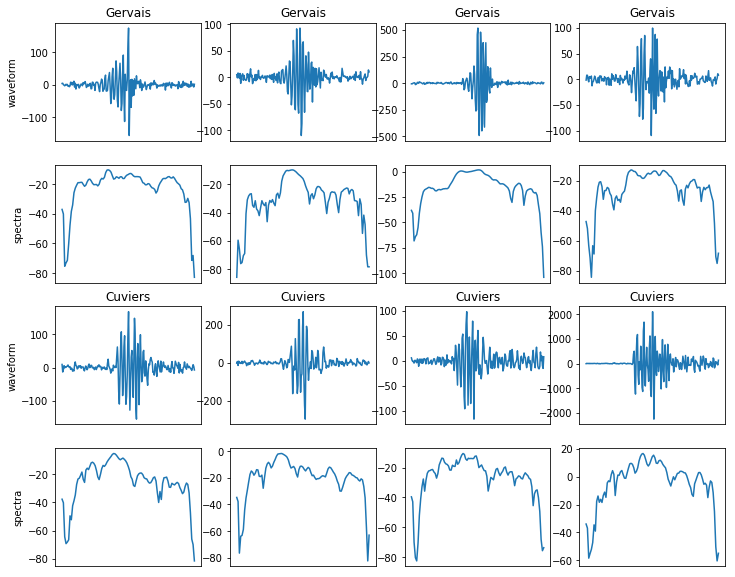

In [16]:
Gervais_4 = Gervais[:4]
Cuviers_4 = Cuviers[:4]

# After creating plot ...

#cur_axes = mplot.gca()
#cur_axes.axes.get_xaxis().set_ticks([])

plt.figure(figsize=(12,10))
i=0

for idx,row in (Gervais_4.append(Cuviers_4)).iterrows():
    waveform=get_msn(row)
    spectra=get_msp(row)
    plt.subplot(4,4,i+1)
    plt.plot(waveform)
    plt.title(row.species)
    plt.gca().axes.get_xaxis().set_ticks([])
    if(i %4)==0:
        plt.ylabel('waveform')
    plt.subplot(4,4,i+5)
    plt.plot(spectra)
    plt.gca().axes.get_xaxis().set_ticks([])
    if(i %4)==0:
        plt.ylabel('spectra')

    i+=1
    if i==4:
        i=8
plt.show()

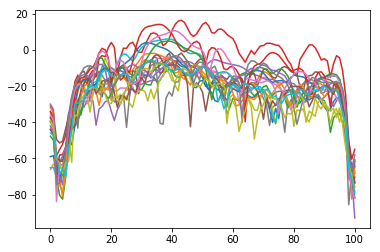

In [17]:
for index, row in df[:20].iterrows():
    spectra=get_msp(row)
    plt.plot(spectra)

In [18]:
df_MSP = pd.DataFrame(df.MSP.apply(lambda x: np.frombuffer(x)).values.tolist())

In [19]:
df_MSP.shape

(4175, 101)

In [20]:
cov = df_MSP.cov()
mean = df_MSP.mean()
var = np.sqrt(df_MSP.var())

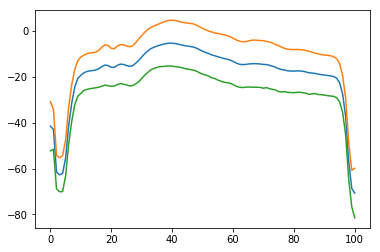

In [21]:
plt.plot(mean)
plt.plot(mean+var)
plt.plot(mean-var)

## FFT Waveform and Frequency Convertion [pdf](https://www.utdallas.edu/~dlm/3350%20comm%20sys/FFTandMatLab-wanjun%20huang.pdf)
- FFT is symmetric, throw away second half

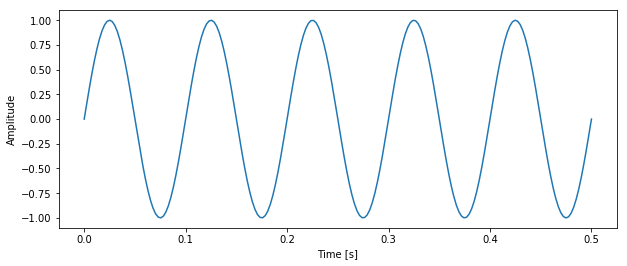

In [22]:
plt.figure(figsize=(10,4))
t = np.linspace(0, 0.5, 200)
s = np.sin(20 * np.pi * t)
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, s)
plt.show()

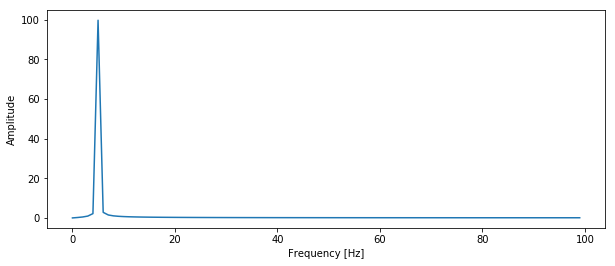

In [23]:
plt.figure(figsize=(10,4))
spectra = np.fft.fft(s)
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.plot(abs(spectra[:len(s)/2]))

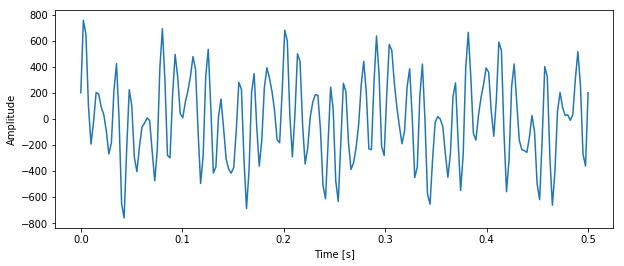

In [24]:
plt.figure(figsize=(10,4))
t = np.linspace(0, 0.5, 200)
s = 100*np.sin(40 * 2 * np.pi * t) +\
    200 * np.sin(90 * 2 * np.pi * t) +\
    350 * np.sin(66 * 2 * np.pi * t) +\
    200 * np.cos(10 * 2 * np.pi * t)

plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(t, s)
plt.show()

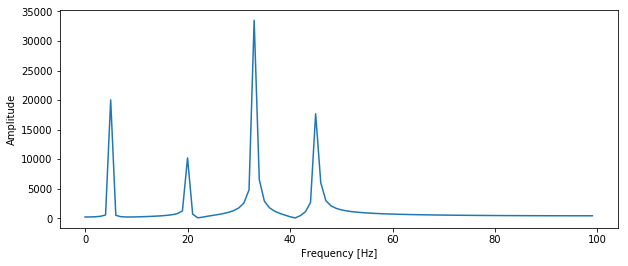

In [25]:
plt.figure(figsize=(10,4))
spectra = np.fft.fft(s)
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.plot(abs(spectra[:len(s)/2]))

Each bump in Frequency Plot corresponds to one type of basic waveform

FFT in original data

In [26]:
df[:1].MSN

0    [249, 15, 233, 183, 175, 163, 34, 64, 191, 125...
Name: MSN, dtype: object

In [27]:
waveform = get_msn(df[:1].squeeze())
spectra = get_msp(df[:1].squeeze())
p2p = df[:1].squeeze(). peak2peak

`peak2peak` which measures the difference between the max and the min of the wave form.

In [28]:
p2p, waveform.max()-waveform.min()

(50.2422, 325.1698)

**_Why peak2peak does not equal to difference between the max and the min of the wave form?_**

In [29]:
waveform[:10]

array([  9.3197, -13.5086,  -6.1229,   5.5962,  -0.8494,   1.726 ,
         0.5058,   3.2518,   4.2202,   7.7504])

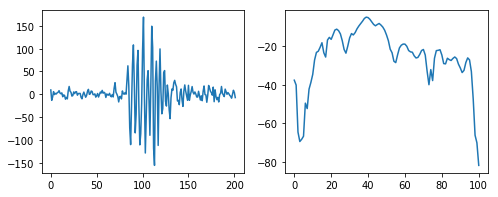

In [30]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(waveform)
plt.subplot(1,2,2)
plt.plot(spectra)

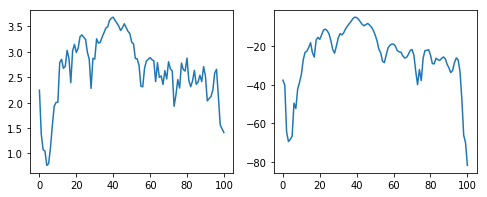

In [51]:
plt.figure(figsize=(8,3))
nfft = 202
sp = np.fft.fft(waveform)
sp = sp[:nfft//2]
plt.subplot(1,2,1)
plt.plot(np.log(np.sqrt(sp)))
plt.subplot(1,2,2)
plt.plot(spectra)

**_Why am I getting a totally different spetrum plot? Why the spectrum looks similar to waveform?_**

## [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) : Principal component analysis FOR data dimension reduction
- STEP 1: Subtract the mean of each variable from the dataset to center the data around the origin
- STEP 2: Compute the covariance matrix of the data, and calculate the eigenvalues and corresponding eigenvectors of this covariance matrix. $COV = (1/n) * X X^T$

- STEP 3: Normalize each of the orthogonal eigenvectors to become unit vectors

$w_{(1)} = arg max {\frac{w^TX^TXw}{w^tw}}$
where $X^TX$ maximum possible value is the largest eigenvalue of the matrix, which occurs when w is the corresponding eigenvector.

$X^TX$ itself can be recognised as proportional to the empirical sample covariance matrix of the dataset X.

In [32]:
from sklearn.decomposition import PCA
X = np.array([[6.7,3.0,5.2,2.3],
              [6.3,2.5,5.0,1.9],
              [6.5,3.0,5.2,2.0],
              [6.2,3.4,5.4,2.3],
              [5.9,3.0,5.1,1.8]])

In [33]:
pca = PCA(n_components=2)
pca.fit(X)
print pca.explained_variance_ratio_
print pca.singular_values_

[0.56849384 0.39960326]
[0.78211212 0.65572334]


In [34]:
pca.fit_transform(X)

array([[-0.25186396, -0.37122049],
       [ 0.50009245, -0.17795188],
       [-0.03944767, -0.12928218],
       [-0.47507938,  0.25665185],
       [ 0.26629856,  0.42180271]])

Cov, following [guide](https://plot.ly/ipython-notebooks/principal-component-analysis/#covariance-matrix)

STEP 1: Subtract the mean of each variable from the dataset to center the data around the origin

In [35]:
X.shape

(5, 4)

In [36]:
X_scaled = X - X.mean(axis=0)

In [37]:
np.cov(X, rowvar=False)

array([[ 0.092 , -0.0095,  0.0055,  0.041 ],
       [-0.0095,  0.102 ,  0.0445,  0.044 ],
       [ 0.0055,  0.0445,  0.022 ,  0.0265],
       [ 0.041 ,  0.044 ,  0.0265,  0.053 ]])

In [38]:
def computeCOV(X, rowvar=False):
    """
    input X is a 2-d np array with shape (Samples, Variances)
    """
    A = X
    if rowvar is True:
        A = X.T
        
    A_scaled = A - A.mean(axis=0)
    return A_scaled.T.dot(A_scaled) / (A.shape[1])

In [39]:
cov = computeCOV(X)
cov

array([[ 0.092 , -0.0095,  0.0055,  0.041 ],
       [-0.0095,  0.102 ,  0.0445,  0.044 ],
       [ 0.0055,  0.0445,  0.022 ,  0.0265],
       [ 0.041 ,  0.044 ,  0.0265,  0.053 ]])

STEP 2: Compute the covariance matrix of the data, and calculate the eigenvalues and corresponding eigenvectors of this covariance matrix. $COV = (1/n) * X X^T$

In [40]:
eig_val, eig_vec = np.linalg.eig(cov)

In [41]:
eig_val

array([0.15292484, 0.10749328, 0.00770884, 0.00087304])

In [42]:
eig_vec

array([[-0.27406699,  0.85756736, -0.43526706, -0.00284472],
       [-0.71943507, -0.44569458, -0.42719752,  0.31823231],
       [-0.36237445, -0.10405413,  0.02921181, -0.9257452 ],
       [-0.52534296,  0.23474944,  0.79195425,  0.20424479]])

In [43]:
sum(eig_vec[:,1]**2)

1.0000000000000002

In [44]:
def topKVec(eig_vec, eig_val, k=2):
    idx = np.argsort(eig_val)[::-1][:k]
    return eig_vec[:,idx]

In [45]:
topKVec(eig_vec, eig_val, k=2)

array([[-0.27406699,  0.85756736],
       [-0.71943507, -0.44569458],
       [-0.36237445, -0.10405413],
       [-0.52534296,  0.23474944]])

In [46]:
tot = sum(eig_val)
var_exp = [(i / tot)*100 for i in sorted(eig_val, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([ 56.84938354,  96.80970917,  99.67544871, 100.        ])

Text(0.5,1,'cumulative explained variance')

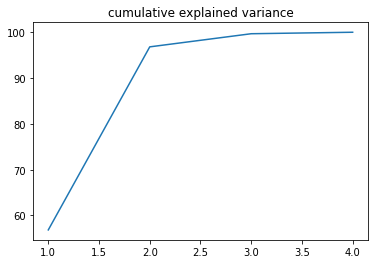

In [47]:
plt.plot(np.arange(1,len(cum_var_exp)+1), cum_var_exp)
plt.title('cumulative explained variance')

STEP 3: Forming the new data set in reduced dimensions, $X_{L} = X W_L$

In [48]:
X_scaled.dot(topKVec(eig_vec, eig_val, k=2))

array([[-0.25186396,  0.37122049],
       [ 0.50009245,  0.17795188],
       [-0.03944767,  0.12928218],
       [-0.47507938, -0.25665185],
       [ 0.26629856, -0.42180271]])